In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer, QuantileTransformer
from catboost import Pool
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
# import dask.dataframe as dd
# import polars as pl
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
%%time
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv', parse_dates=['date'])

idx = test['id']

CPU times: user 306 ms, sys: 59.2 ms, total: 365 ms
Wall time: 563 ms


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_sold', ylabel='Density'>

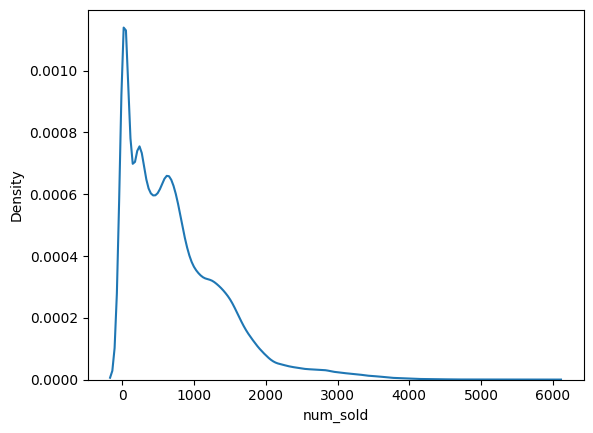

In [3]:
sns.kdeplot(train['num_sold'].dropna())

In [4]:
# train['date'] = pd.to_datetime(train['date'], errors='coerce')

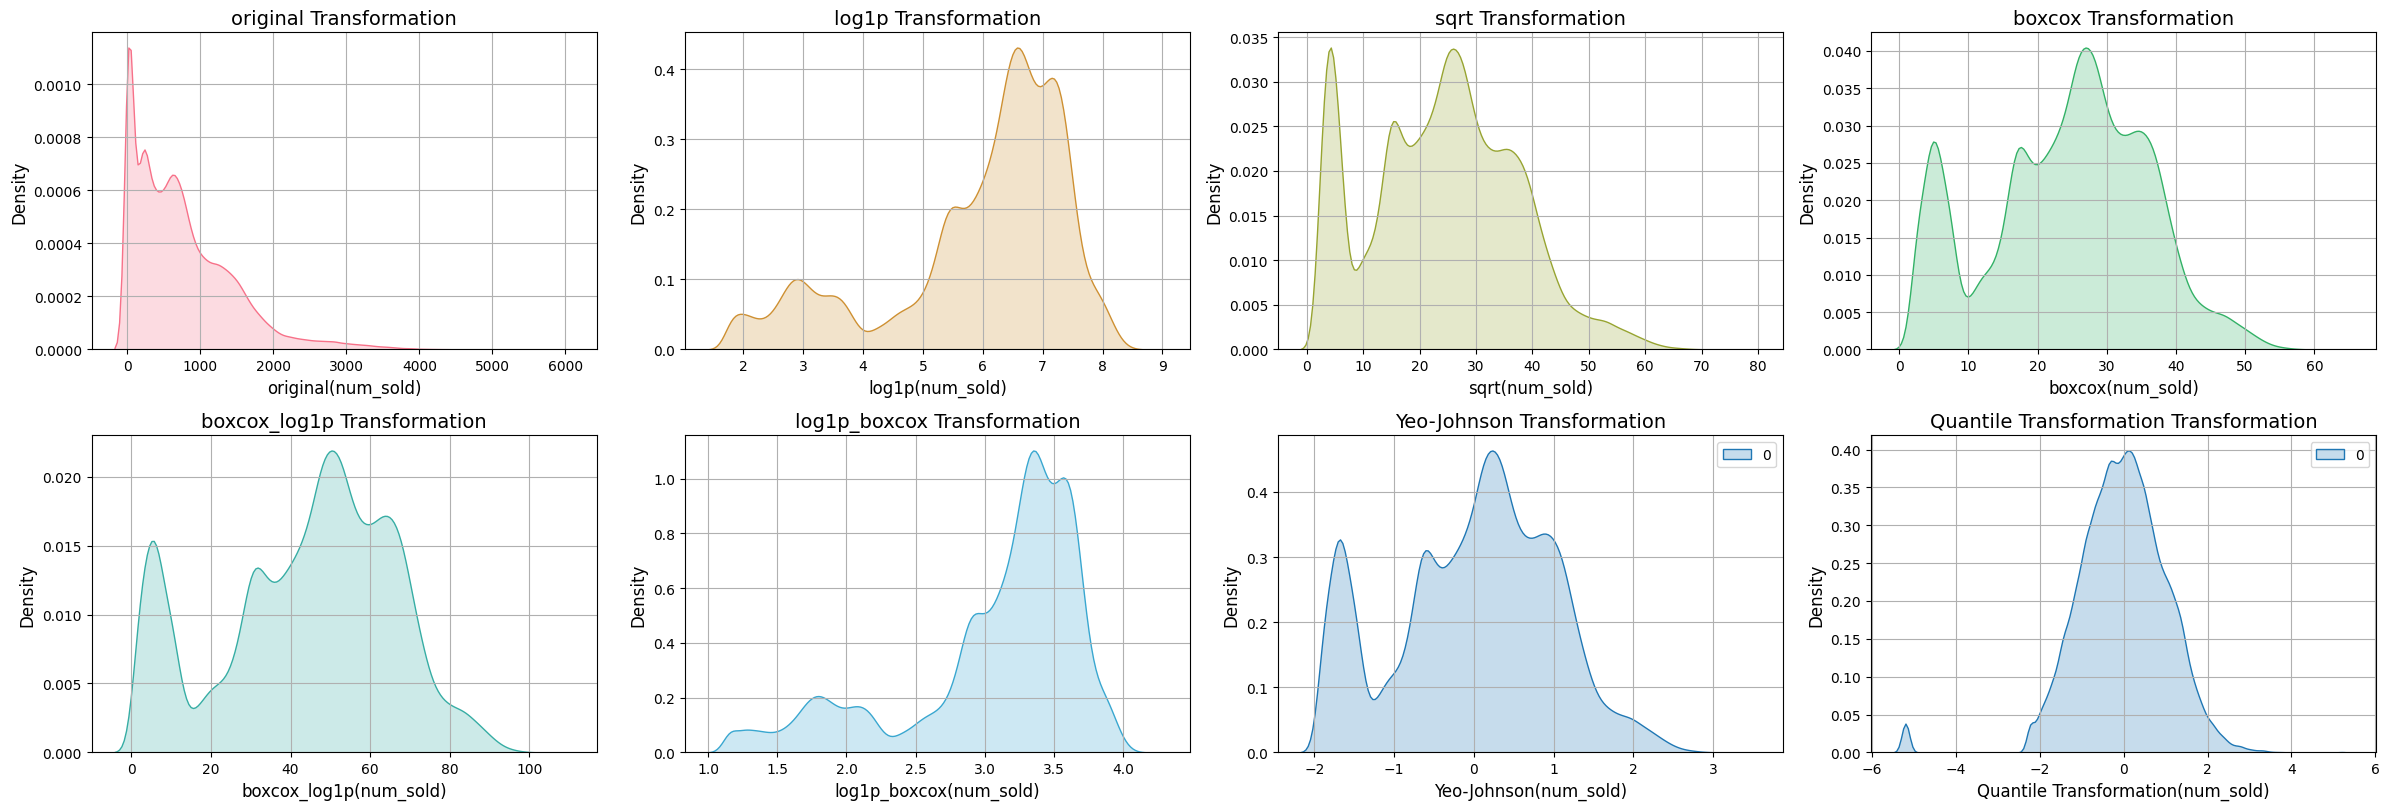

In [5]:
import warnings
warnings.filterwarnings('ignore')
def visualize_transformations(df, target_col):
    target = df[target_col].dropna()

    transformations = {}
    transformations['original'] = target
    transformations['log1p'] = np.log1p(target)
    transformations['sqrt'] = np.sqrt(target)
    transformations['boxcox'], Iam = boxcox(target)
    transformations['boxcox_log1p'], Iam_2 = boxcox(transformations['log1p'])
    transformations['log1p_boxcox'] = np.log1p(transformations['boxcox'])

    pt = PowerTransformer(method='yeo-johnson')
    transformations['Yeo-Johnson'] = pt.fit_transform(target.values.reshape(-1,1))

    qt = QuantileTransformer(n_quantiles=8000, output_distribution='normal', random_state=42)
    transformations['Quantile Transformation'] = qt.fit_transform(target.values.reshape(-1,1))

    num_transformations = len(transformations)
    cols = 4
    rows = (num_transformations + cols - 1) 
    plt.figure(figsize=(cols * 6, rows * 4))
    palette = sns.color_palette("husl", num_transformations)

    for idx, (name, data) in enumerate(transformations.items(), 1):
        plt.subplot(rows, cols, idx)
        sns.kdeplot(data, shade=True, color=palette[idx-1])
        plt.title(f'{name} Transformation', fontsize=14)
        plt.xlabel(target_col if name == 'Original' else f'{name}({target_col})', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()


visualize_transformations(train, 'num_sold')

In [6]:
def new_features(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['day_of_month'] = df['date'].dt.day
    df['days_in_month'] = df['date'].dt.days_in_month
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.weekday
    df['day_of_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter
    df['is_month_start'] = df['date'].dt.is_month_start
    df['is_month_end'] = df['date'].dt.is_month_end
    df['is_quarter_start'] = df['date'].dt.is_quarter_start
    df['is_year_start'] = df['date'].dt.is_year_start
    df['is_year_end'] = df['date'].dt.is_year_end
    df['is_leap_year'] = df['date'].dt.is_leap_year
    df['daysinmonth'] = df['date'].dt.daysinmonth
    
    df['week_of_year'] = (df['date'].dt.isocalendar().week).astype('int32')
    df['is_weekened'] = (df['day_of_week']>5).astype('int32')

    df['day_of_week_sin'] = np.sin((2*np.pi*df['day_of_week'])/7)
    df['day_of_week_cos'] = np.cos((2*np.pi*df['day_of_week'])/7)
    df['week_of_year_sin'] = np.sin((2*np.pi*df['week_of_year'])/52)
    df['week_of_year_cos'] = np.cos((2*np.pi*df['week_of_year'])/52)
    df['day_of_month_sin'] = np.sin((2*np.pi*df['day_of_month'])/df['days_in_month'])
    df['day_of_month_cos'] = np.cos((2*np.pi*df['day_of_month'])/df['days_in_month'])
    df['day_of_year_sin'] = np.sin((2*np.pi*df['day_of_year'])/365)
    df['day_of_year_cos'] = np.cos((2*np.pi*df['day_of_year'])/365)
    df['quarter_sin'] = np.sin((2*np.pi*df['quarter'])/np.max(df['quarter']))
    df['quarter_cos'] = np.cos((2*np.pi*df['quarter'])/np.max(df['quarter']))
    df['month_sin'] = np.sin((2*np.pi*df['month'])/12)
    df['month_cos'] = np.cos((2*np.pi*df['month'])/12)

    # df.drop(columns='date', inplace=True)

    return df

In [7]:
# def preprocessing(df):
#     encoder = OrdinalEncoder()
#     cat_dtypes = df.select

In [8]:
train = new_features(train)
test = new_features(test)

In [9]:
import requests

def gdp_per_capita(alpha3, year):
    url = f'https://api.worldbank.org/v2/country/{alpha3}/indicator/NY.GDP.PCAP.CD?date={year}&format=json'
    try:
        response = requests.get(url).json()
        if response[1]:
            return  response[1][0].get('value')
    except (IndexError, KeyError, ValueError):
        return None

alpha3s = {
    'Canada':'CAN',
    'Finland':'FIN',
    'Italy':'ITA',
    'Kenya':'KEN',
    'Norway':'NOR',
    'Singapore':'SGP'
}
# alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
train['country_code'] = train['country'].map(alpha3s)
test['country_code'] = test['country'].map(alpha3s)
unique_years = np.sort(np.unique(np.concatenate([train['year'], test['year']])))
gdp = {}
for _, code in alpha3s.items():
    for year in unique_years:
        gdp[(code, year)] = gdp_per_capita(code, year)

    
train['gdp'] = train.apply(lambda row : gdp[(row['country_code'], row['year'])], axis=1)
test['gdp'] = test.apply(lambda row : gdp[(row['country_code'], row['year'])], axis=1)
        
# train['gdp_per_capita'] = train.apply(lambda row: gdp_per_capita(row['country_code'], row['year']), axis=1)

In [10]:
gdp_df = pd.DataFrame(
    [(key[0], key[1], value) for key, value in gdp.items()],
    columns=['country_code', 'year', 'gdp'])
gdp_ratio = {}
year_gdp_total = {}
for year in unique_years:
    year_gdp_total[year] = np.sum(gdp_df.loc[gdp_df['year']==year, 'gdp'])

for (country_code, year), gdp_value in gdp.items():
    gdp_ratio[(country_code, year)] = gdp[(country_code, year)] / year_gdp_total[year] 

gdp_ratio_df = pd.DataFrame(
    [(key[0], key[1], value) for key, value in gdp_ratio.items()],
    columns = ['country_code', 'year', 'country_year_gdp_ratio']
)

In [11]:
gdp_ratio_df['year'] = gdp_ratio_df['year'].astype(str) + '-12-31'
gdp_ratio_df['year'] = pd.to_datetime(gdp_ratio_df['year'])
gdp_ratio_df.rename(columns={'year':'date'}, inplace=True)
gdp_ratio_df['year'] = gdp_ratio_df['date'].dt.year
gdp_ratio_df.head(5)

,country_code,date,country_year_gdp_ratio,year
0,CAN,2010-12-31,0.178521,2010
1,CAN,2011-12-31,0.175291,2011
2,CAN,2012-12-31,0.179099,2012
3,CAN,2013-12-31,0.175505,2013
4,CAN,2014-12-31,0.173468,2014


In [12]:
train['gdp_ratio'] = np.nan
test['gdp_ratio'] = np.nan
for (country_code, year), gdp in gdp_ratio.items():
    train.loc[(train['year']==year) & (train['country_code']==country_code), 'gdp_ratio'] = gdp
    test.loc[(test['year']==year) & (test['country_code']==country_code), 'gdp_ratio'] = gdp

In [13]:
target_ratio = gdp_ratio_df.loc[(gdp_ratio_df['country_code']=='NOR') & (gdp_ratio_df['year']==2010), 'country_year_gdp_ratio'].values[0]
can_ratio = gdp_ratio_df.loc[(gdp_ratio_df['country_code']=='CAN') & (gdp_ratio_df['year']==2010), 'country_year_gdp_ratio'].values[0]

In [14]:
cat_dtypes = train.select_dtypes(include=['object', 'category']).columns
train[cat_dtypes] = train[cat_dtypes].astype('category')
test[cat_dtypes] = test[cat_dtypes].astype('category')
cat_dtypes = [col for col in cat_dtypes if col!='date']
cat_dtypes.append('year')
cat_dtypes

['country', 'store', 'product', 'country_code', 'year']

In [15]:
for col in cat_dtypes:
    print(f'value_counts for {col} :', train[col].value_counts())
    print('-----------------------')

value_counts for country : country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64
-----------------------
value_counts for store : store
Discount Stickers       76710
Premium Sticker Mart    76710
Stickers for Less       76710
Name: count, dtype: int64
-----------------------
value_counts for product : product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64
-----------------------
value_counts for country_code : country_code
CAN    38355
FIN    38355
ITA    38355
KEN    38355
NOR    38355
SGP    38355
Name: count, dtype: int64
-----------------------
value_counts for year : year
2012    32940
2016    32940
2010    32850
2011    32850
2013    32850
2014    32850
2015    32850
Name: count, dtype: int64
-----------------------


In [16]:
mask = train[train['num_sold'].isnull()].index.to_list()
for col in cat_dtypes:
    if cat_dtypes!='country':
        print(f'missing num_sold values in {col} :', train[col].iloc[mask].value_counts())
        print('------------------')

missing num_sold values in country : country
Kenya        4625
Canada       4246
Finland         0
Italy           0
Norway          0
Singapore       0
Name: count, dtype: int64
------------------
missing num_sold values in store : store
Discount Stickers       5179
Stickers for Less       2666
Premium Sticker Mart    1026
Name: count, dtype: int64
------------------
missing num_sold values in product : product
Holographic Goose     8806
Kerneler                64
Kerneler Dark Mode       1
Kaggle                   0
Kaggle Tiers             0
Name: count, dtype: int64
------------------
missing num_sold values in country_code : country_code
KEN    4625
CAN    4246
FIN       0
ITA       0
NOR       0
SGP       0
Name: count, dtype: int64
------------------
missing num_sold values in year : year
2010    1709
2011    1405
2012    1221
2015    1207
2016    1173
2013    1129
2014    1027
Name: count, dtype: int64
------------------


In [17]:
train.to_csv('train_pss5e1.csv', index=False)
test.to_csv('test_pss5e1.csv', index=False)

In [18]:
cols_to_drop = ['id', 'country_code']
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)

In [19]:
# train.drop(columns='date', inplace=True)
# test.drop(columns='date', inplace=True)

In [20]:
encoder = OrdinalEncoder()
cat_dtypes = train.select_dtypes(include=['object', 'category']).columns
train[cat_dtypes] = train[cat_dtypes].astype('category')
print(cat_dtypes)
train[cat_dtypes] = encoder.fit_transform(train[cat_dtypes])
test[cat_dtypes] = encoder.transform(test[cat_dtypes])

Index(['country', 'store', 'product'], dtype='object')


In [21]:
train.dropna(subset=['num_sold'], inplace=True)

In [22]:
train['num_sold'].isnull().sum()

0

In [23]:
# y_transformed, Iam = boxcox(y+1)
# qt = QuantileTransformer(n_quantiles = 89000, subsample=100000, output_distribution='normal', random_state=42)
# def remove_outliers(df, target_col):
#     df[target_col] = qt.fit_transform(df[target_col].values.reshape(-1,1)).flatten()
#     sns.kdeplot(df[target_col], shade=True, color='red')
#     Q1 = df[target_col].quantile(0.25)
#     Q3 = df[target_col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 3.25 * IQR
#     upper_bound = Q3 + 4 * IQR

#     df_cleaned = df[(df[target_col]>=lower_bound) & (df[target_col]<=upper_bound)].copy()
#     return df_cleaned
# # train = remove_outliers(train, 'num_sold')
# sns.kdeplot(train['num_sold'], shade=True, color = 'green')
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)
X = train.drop(columns='num_sold')
y, lmbda = boxcox(train['num_sold'])
# y = np.log1p(train['num_sold'])

In [24]:
def cv_score(X, y, model, name, splits=20):
    skf = KFold(splits, shuffle=True, random_state=42)
    tscv = TimeSeriesSplit(splits)
    if name!='cat':
        cv_scores = cross_val_score(model, X, y, cv=skf, scoring='neg_mean_absolute_percentage_error')
        cv_scores = cv_scores*-1
        print(f'{name} score on cross-val :', cv_scores.mean(), ' with deviation :', cv_scores.std())

    else:
        y = pd.Series(y)
        index = []
        preds = []
        scores = []
        for i, (train_index, valid_index) in enumerate(tscv.split(X, y)):
            train_pool = Pool(data=X.iloc[list(train_index)], label=y.iloc[list(train_index)], cat_features=X.iloc[train_index][cat_dtypes].columns.values)
            valid_pool = Pool(data=X.iloc[list(valid_index)], label=y.iloc[list(valid_index)], cat_features=X.iloc[valid_index][cat_dtypes].columns.values)
            index.extend(valid_index)
            model.fit(train_pool)
            preds = model.predict(valid_pool)
            score = mean_absolute_percentage_error(preds, y.iloc[valid_index])
            scores.append(score)
            print(f'Score for fold {i} :', score)
        print('mean_score :', np.mean(scores))

In [25]:
# xgb_model = xgb.XGBRegressor(random_state=42, enable_categorical=True)
# cv_score(X, y, xgb_model, 'XGB_Reg')

In [26]:
# linear_reg = LinearRegression()
# cv_score(X, y, linear_reg, 'linear_reg')

In [27]:
lgb_model = lgb.LGBMRegressor(random_state=-1, enable_categorical=True, verbosity=-1)
cb_model = cb.CatBoostRegressor(random_state=1, verbose=0)
# cv_score(X, y, cb_model, 'cat')
# cv_score(X, y, lgb_model, 'lgbm')

In [28]:
# test.drop(columns='id', inplace=True)
# test[cat_dtypes] = test[cat_dtypes].astype('category')

In [29]:
# y = pd.Series(y)
# train_pool = Pool(data=X, label=y, cat_features=X[cat_dtypes].columns.values)
# test_pool = Pool(data=test, cat_features=X[cat_dtypes].columns.values)
# cb_model.fit(train_pool)

In [30]:
lgb_model.fit(X, y)

LGBMRegressor(enable_categorical=True, random_state=-1, verbosity=-1)

In [31]:
preds = lgb_model.predict(test)

In [32]:
# def inverse_quantile(y_transformed):
#      y_transformed = qt.inverse_transform(y_transformed.reshape(-1,1)).flatten()
#      return y_transformed

def inverse_boxcox(y_transformed, lmbda):
    if lmbda==0:
        return np.exp(y_transformed)
    else:
        return np.power(y_transformed*lmbda+1, 1/lmbda)
# preds = inverse_quantile(preds)
print(preds)
preds = preds - 1 
preds = inverse_boxcox(preds, lmbda)
# preds = np.expm1(preds)

[14.48435189 30.13758834 28.27659916 ... 45.22176967 36.15531503
 37.84411145]


In [33]:
preds

array([ 130.46301131,  829.07661705,  703.18411605, ..., 2394.80109969,
       1331.10329665, 1499.87387133])

In [34]:
# def inverse_boxcox(y_transformed, Iam):
#     if Iam==0:
#         return np.exp(y_transformed) - 1
#     else:
#         return np.power(y_transformed*Iam+1, 1 / Iam) - 1

# preds = inverse_boxcox(preds, Iam)

In [35]:
submission_df = pd.DataFrame({
    'id':idx,
    'num_sold':preds
})
submission_df.to_csv('submission.csv', index=False)

In [36]:
# train.drop(columns = 'gdp_ratio', inplace=True)

In [37]:
# train.to_csv('pss5e1_train.csv', index=False)
# test.to_csv('pss5e1_test.csv', index=False)